In [1]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Dataset visualization

In [2]:
import lzma
import pickle
from gensim.matutils import corpus2csc, unitvec
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.preprocessing as preprocessing
# from scikits.sparse.cholmod import cholesky

import dataset
from dataset import common_dictionary, common_embedding_matrices

# with lzma.open('matrices/termsim-1-True-True-True-600.pkl.xz', 'rb') as f:
#     sparse_embedding_matrix = pickle.load(f)
# sparse_embedding_matrix = cholesky(embedding_matrix).L()
# with lzma.open('matrices/cholesky-1-True-True-True-600.pkl.xz', 'wb') as f:
#     pickle.dump(sparse_embedding_matrix, f)
with lzma.open('matrices/cholesky-1-True-True-True-600.pkl.xz', 'rb') as f:
    sparse_embedding_matrix = pickle.load(f)

dense_embedding_matrix = common_embedding_matrices[32]
dense_embedding_matrix = preprocessing.normalize(dense_embedding_matrix, norm='l2')

dataset_names = ['bbcsport', 'twitter', 'bbc', 'ohsumed', 'reuters', 'amazon', '20news']

2019-02-18 00:52:19,543 : INFO : 'pattern' package not found; tag filters are not available for English
2019-02-18 00:52:19,759 : INFO : Loading dataset from file corpora/fil8.pkl.xz.
2019-02-18 00:52:25,794 : INFO : loading projection weights from vectors/1b_1000d_vectors_e10_nonbin
2019-02-18 00:53:14,381 : INFO : loaded (60238, 1000) matrix from vectors/1b_1000d_vectors_e10_nonbin
2019-02-18 00:53:14,382 : INFO : loading projection weights from vectors/32b_200d_vectors_e10_nonbin
2019-02-18 00:53:25,839 : INFO : loaded (60238, 200) matrix from vectors/32b_200d_vectors_e10_nonbin


2019-02-18 00:56:12,859 : INFO : Loading dataset from file corpora/bbcsport_train.pkl.xz.
2019-02-18 00:56:12,941 : INFO : Loading dataset from file corpora/bbcsport_validation.pkl.xz.
2019-02-18 00:56:12,963 : INFO : Loading dataset from file corpora/bbcsport_test.pkl.xz.
2019-02-18 00:58:06,028 : INFO : Loading dataset from file corpora/twitter_train.pkl.xz.
2019-02-18 00:58:06,054 : INFO : Loading dataset from file corpora/twitter_validation.pkl.xz.
2019-02-18 00:58:06,062 : INFO : Loading dataset from file corpora/twitter_test.pkl.xz.
2019-02-18 01:03:10,360 : INFO : Loading dataset from file corpora/bbc_train.pkl.xz.
2019-02-18 01:03:10,599 : INFO : Loading dataset from file corpora/bbc_validation.pkl.xz.
2019-02-18 01:03:10,663 : INFO : Loading dataset from file corpora/bbc_test.pkl.xz.
2019-02-18 01:07:14,485 : INFO : Loading dataset from file corpora/ohsumed_train.pkl.xz.
2019-02-18 01:07:14,777 : INFO : Loading dataset from file corpora/ohsumed_validation.pkl.xz.
2019-02-18 01

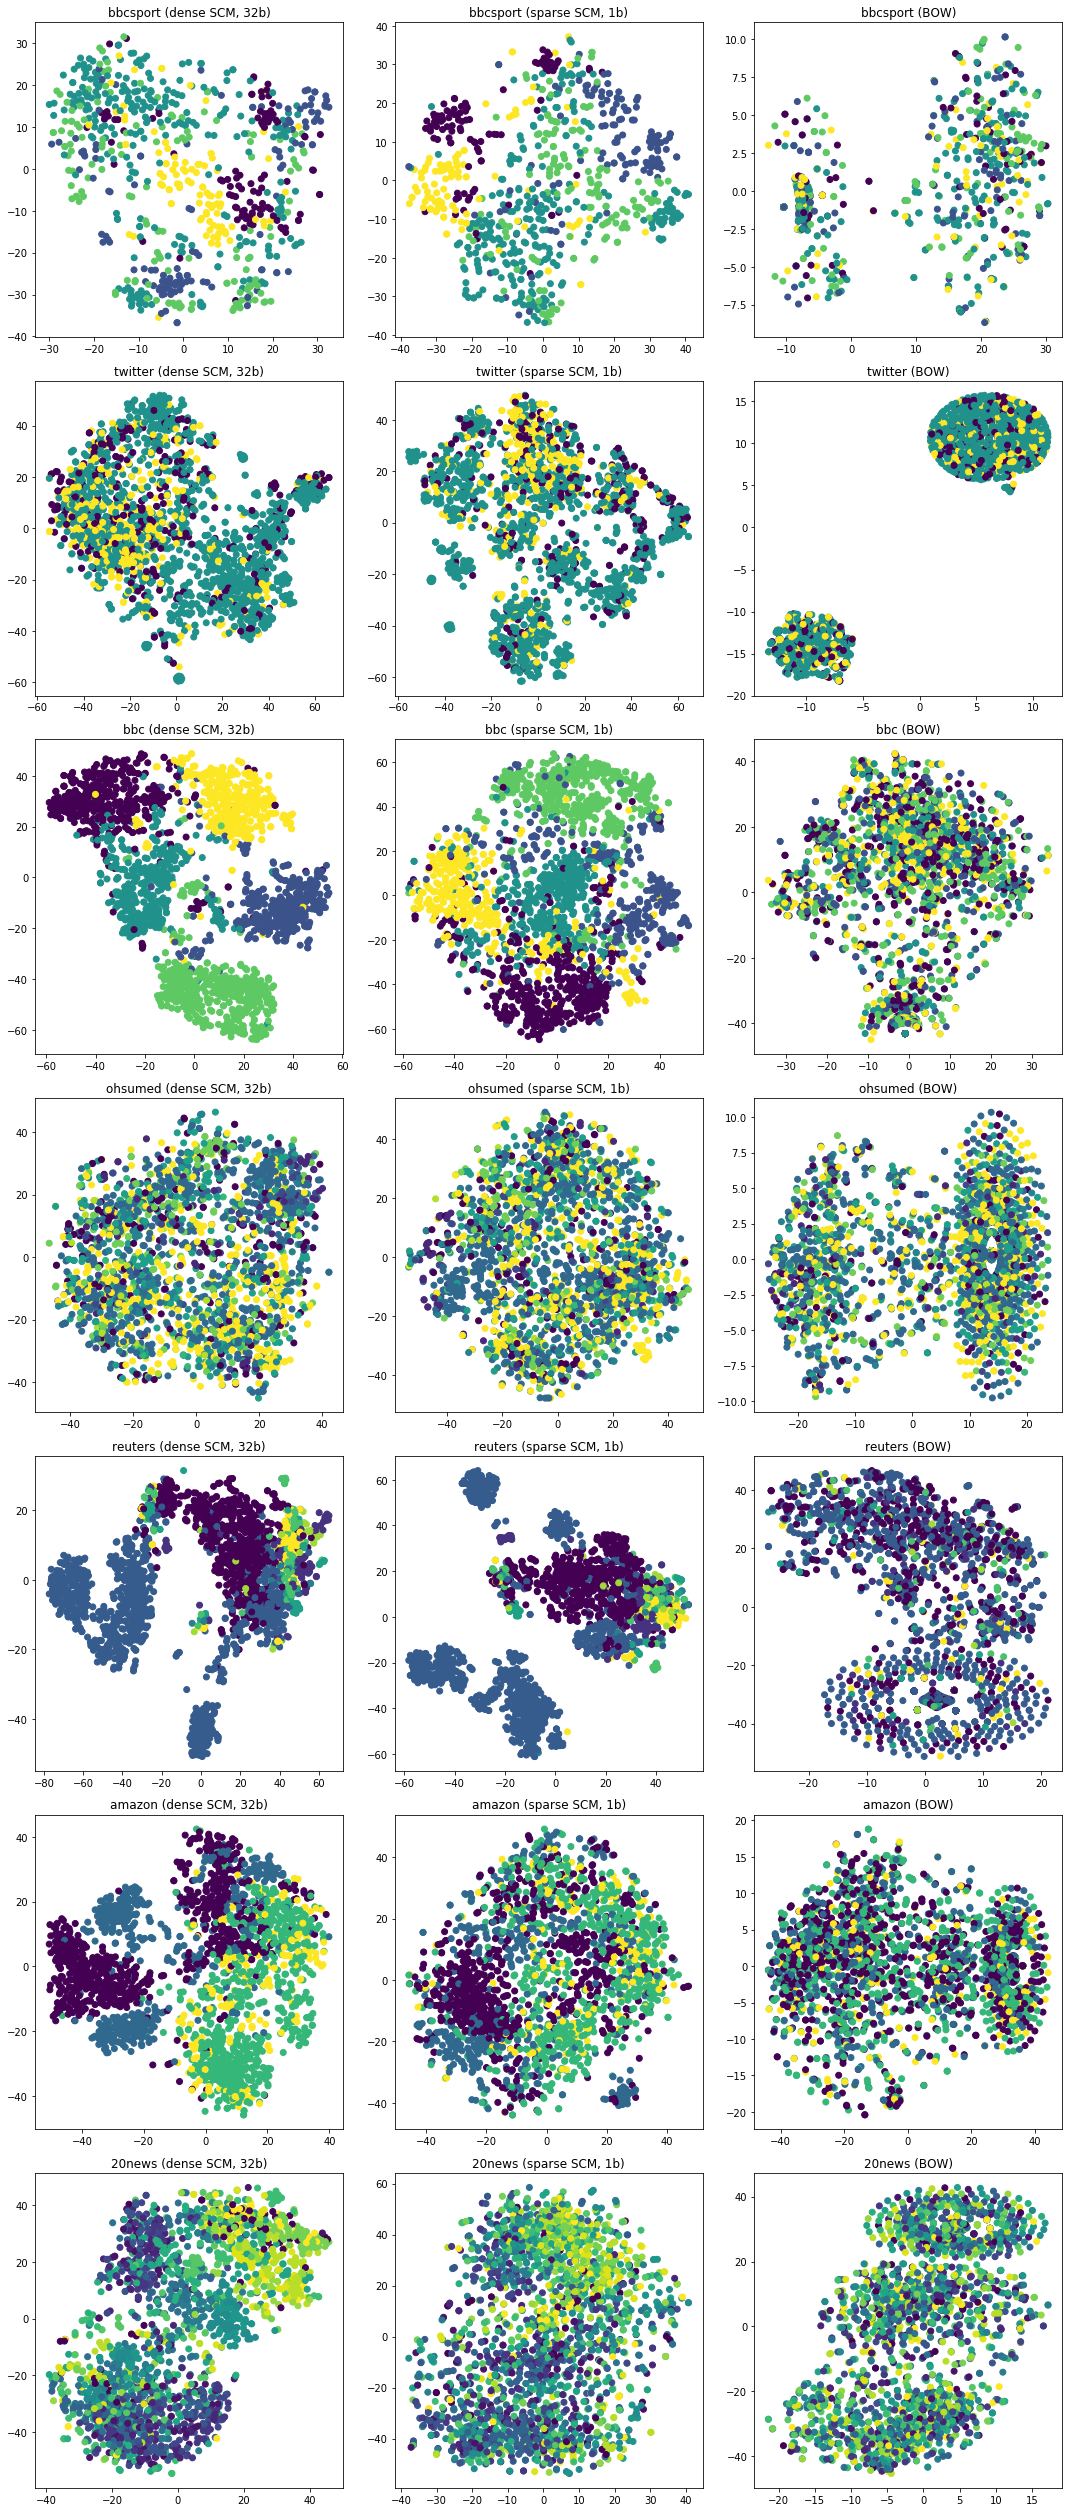

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

plt.figure(figsize=(15, 5 * len(dataset_names)))
for dataset_number, dataset_name in enumerate(dataset_names):
    train, validation, test = dataset.__dict__['load_{}'.format(dataset_name)]()
    X = train.corpus + validation.corpus + test.corpus
    Y = np.array(train.target + validation.target + test.target, dtype=int)
    np.random.seed(42)
    sample = np.random.choice(len(X), min(len(X), 2000), replace=False)

    X_dense_soft_vsm = map(common_dictionary.doc2bow, X)
    X_dense_soft_vsm = map(unitvec, X_dense_soft_vsm)
    X_dense_soft_vsm = corpus2csc(X_dense_soft_vsm, len(common_dictionary))
    X_dense_soft_vsm = scipy.sparse.csc_matrix.dot(
        dense_embedding_matrix.T,
        X_dense_soft_vsm,
    ).T
    X_dense_soft_vsm = PCA(n_components=50).fit_transform(X_dense_soft_vsm)
    X_dense_soft_vsm = X_dense_soft_vsm[sample]
    Y_dense_soft_vsm = Y[sample]
    X_dense_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_dense_soft_vsm)
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 1)
    ax.set_title('{} (dense SCM, 32b)'.format(dataset_name))
    ax.scatter(*X_dense_soft_vsm.T, c=Y_dense_soft_vsm)
    
    X_sparse_soft_vsm = map(common_dictionary.doc2bow, X)
    X_sparse_soft_vsm = map(unitvec, X_sparse_soft_vsm)
    X_sparse_soft_vsm = corpus2csc(X_sparse_soft_vsm, len(common_dictionary))
    X_sparse_soft_vsm_norm = X_sparse_soft_vsm.T.dot(sparse_embedding_matrix).multiply(X_sparse_soft_vsm.T).sum(axis=1).T
    X_sparse_soft_vsm = X_sparse_soft_vsm.multiply(scipy.sparse.csr_matrix(1 / np.sqrt(X_sparse_soft_vsm_norm)))
    X_sparse_soft_vsm = scipy.sparse.csc_matrix.dot(sparse_embedding_matrix.T, X_sparse_soft_vsm).T.todense()
    X_sparse_soft_vsm = PCA(n_components=50).fit_transform(X_sparse_soft_vsm)
    X_sparse_soft_vsm = X_sparse_soft_vsm[sample]
    Y_sparse_soft_vsm = Y[sample]
    X_sparse_soft_vsm = TSNE(n_components=2, metric='cosine').fit_transform(X_sparse_soft_vsm)
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 2)
    ax.set_title('{} (sparse SCM, 1b)'.format(dataset_name))
    ax.scatter(*X_sparse_soft_vsm.T, c=Y_sparse_soft_vsm)

    X_bow = map(common_dictionary.doc2bow, X)
    X_bow = map(unitvec, X_bow)
    X_bow = corpus2csc(X_bow, len(common_dictionary)).todense()
    X_bow = PCA(n_components=50).fit_transform(X_bow)
    X_bow = X_bow[sample]
    Y_bow = Y[sample]
    X_bow = TSNE(n_components=2, metric='cosine').fit_transform(X_bow)
    
    ax = plt.subplot(len(dataset_names), 3, dataset_number * 3 + 3)
    ax.set_title('{} (BOW)'.format(dataset_name))
    ax.scatter(*X_bow.T, c=Y_bow)

plt.tight_layout()
plt.savefig('figures/experiments-datasets.pdf')
plt.show()

# Sparse Term Similarity Matrices

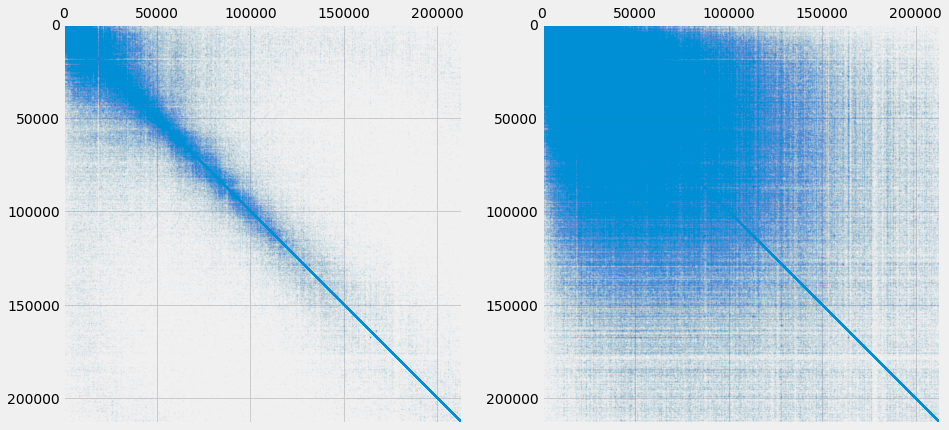

In [159]:
%matplotlib inline
from common import cached_sparse_term_similarity_matrix
from scipy.sparse import coo_matrix
    
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(121)
embedding_matrix = cached_sparse_term_similarity_matrix('32-True-True-True-600')
ax.spy(embedding_matrix, markersize=0.005)

ax = fig.add_subplot(122)
embedding_matrix = cached_sparse_term_similarity_matrix('1-True-True-True-600')
ax.spy(embedding_matrix, markersize=0.005)

plt.show()

# Confusion Matrices

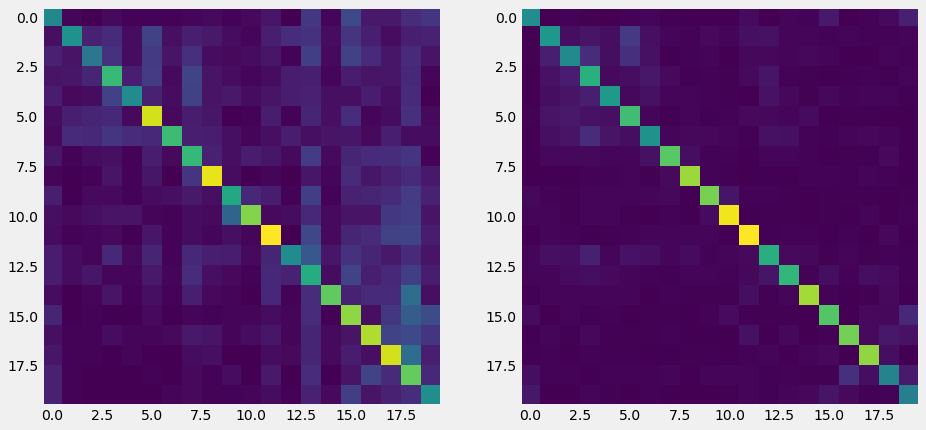

In [160]:
fig = plt.figure(figsize=(14, 14))

ax = fig.add_subplot(121)
result = results['20news'][('vsm', 'bow', 'inner_product', 32)]
ax.imshow(result.confusion_matrix, interpolation='nearest')
ax.grid(None)

ax = fig.add_subplot(122)
result = results['20news'][('sparse_soft_vsm', 'tfidf', 'inner_product', 1)]
ax.imshow(result.confusion_matrix, interpolation='nearest')
ax.grid(None)

plt.show()